# Assignment (Healthcare and Artificial Intelligence)
The objective of this assignment is to get you familiarize with  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://iiitaphyd-my.sharepoint.com/personal/manasa_k_research_iiit_ac_in/_layouts/15/onedrive.aspx?ct=1622206906840&or=OWA).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `name.ipynb` and submit the notebook file on Github Repo with plots/vizualizations saved.


In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 64,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 64, 64)


In [5]:
X.shape

(400, 64, 64)

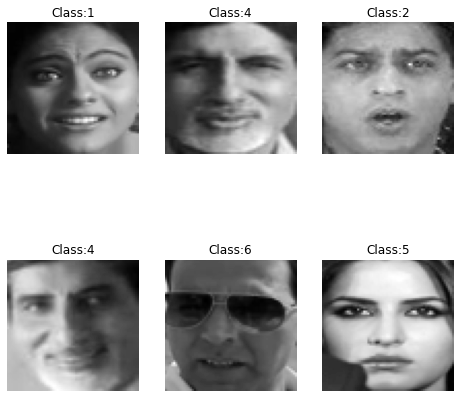

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [7]:
dirpath = './dataset/IIIT-CFW/'
X_1,y_1 = load_data(dirpath)
N_1,H_1,W_1 = X_1.shape[0:3]
C = 1 if opt['is_grayscale'] else X_1.shape[3]

Dataset shape: (672, 64, 64)


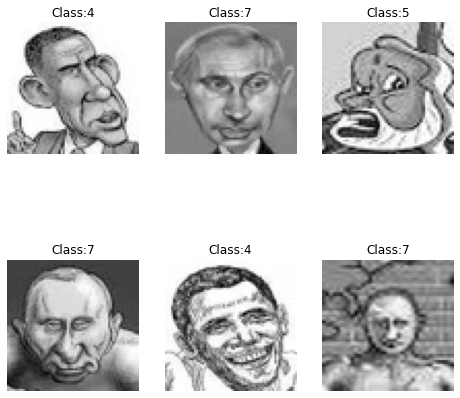

In [8]:
# Show sample images
ind = np.random.randint(0,y_1.shape[0],6)
disply_images(X_1[ind,...],y_1[ind], row=2,col=3)

In [9]:
dirpath = './dataset/Yale_face_database/'
X_2,y_2 = load_data(dirpath)
N_2,H_2,W_2 = X_2.shape[0:3]
C = 1 if opt['is_grayscale'] else X_2.shape[3]

Dataset shape: (165, 64, 64)


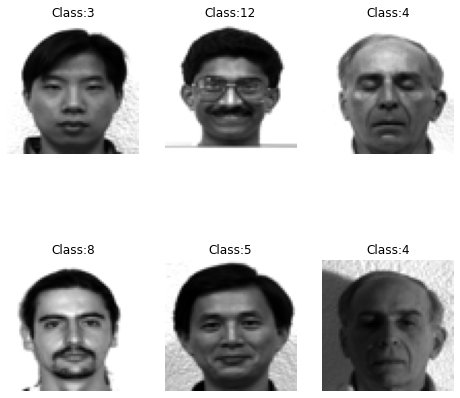

In [10]:
# Show sample images
ind = np.random.randint(0,y_2.shape[0],6)
disply_images(X_2[ind,...],y_2[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features


---


In [11]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [12]:
X_1 = X_1.reshape((N_1,H_1*W_1*C))

In [13]:
X_2 = X_2.reshape((N_2,H_2*W_2*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [14]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [15]:
def get_pca(X,k,y):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=0.1)
    n_components = k
    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, Xtrain.shape[0]))
    #t0 = time()
    pca = PCA(n_components=n_components)
    Xtrain=pca.fit_transform(Xtrain)
    X_k=pca.transform(Xtest)
    #print("done in %0.3fs" % (time() - t0))
    test=pca.inverse_transform(Xtrain)
    test=test.reshape((604,64,64)) #Change Size as per Dataset
    plt.imshow(test[20],cmap='gray')

    return X_k,pca.components_

Extracting the top 100 eigenfaces from 604 faces


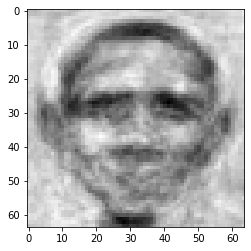

In [16]:
X_k,eigenfaces= get_pca(X_1,100,y_1)

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [25]:
def get_kernel_pca(X, k, y,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    #Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=0.1)
    kpca= KernelPCA(n_components=k,kernel=kernel,fit_inverse_transform='True')
    X=kpca.fit_transform(X)
    #X_k=kpca.transform(Xtest)
    test=kpca.inverse_transform(X)
    print(test.shape)
    test=test.reshape((672,64,64))#Change Size as per Dataset
    print(test.shape)
    plt.imshow(test[10],cmap='gray')
    print(kpca.X_transformed_fit_.shape)
    K = kpca._get_kernel(X, kpca.X_transformed_fit_)
    return K,kpca.dual_coef_

(672, 4096)
(672, 64, 64)
(672, 350)


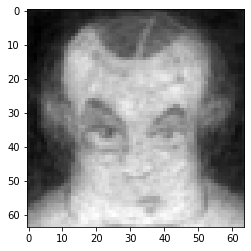

In [26]:
X_k,eigenfaces= get_kernel_pca(X_1,350,y_1,'cosine')

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.


Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [645]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    [n,d]=X.shape
    c =len(np.unique(y))
    pca=PCA(n-c)
    X=pca.fit_transform(X)
    eigen_pca=pca.components_
    lda=LDA(n_components=k,store_covariance=True)
    X=lda.fit_transform(X,y)
    eigen_lda=lda.scalings_
    X_k=np.dot(eigen_lda.T,eigen_pca)
    
    return X_k,X

In [646]:
fischerfaces,X= get_lda(X_1,y_1,4)

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [28]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    [n,d]=X.shape
    c =len(np.unique(y))
    pca=KernelPCA(n-c, kernel=kernel)
    X=pca.fit_transform(X)
    lda=LDA(n_components=k)
    X_k=lda.fit_transform(X,y)
    return X_k

In [30]:
fischerfaces= get_kernel_lda(X,y,7)

(400, 7)


### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.


In [120]:
def get_vgg_features(dirpath):
    model= np.load(dirpath+'/VGG19_features.npy')
    features=[]
    for i in range (model.shape[0]):
        features.append(model[i])
    features=np.asarray(features)
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 



In [47]:
def get_resnet_features(dirpath):
    model= np.load(dirpath+'/resnet50_features.npy')
    features=[]
    for i in range (model.shape[0]):
        features.append(model[i])
    features=np.asarray(features)
    return features

# Questions

1(a). What are eigen faces? 


1(b). How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.
   

1(c). Reconstruct  the  image  back for each case


In [17]:
def reconstruct_images(eigenvectors, X_k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    reconstruct_X = np.dot(X_k, eigenvectors)

    
    
    return reconstruct_X    

(672, 64, 64)


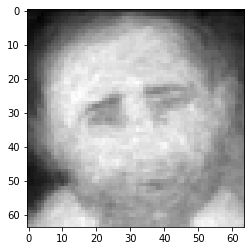

In [27]:
Xhat=reconstruct_images(eigenfaces, X_k)
Xhat=Xhat.reshape((672,64,64)) #Changes Sizes as per dataset
print(Xhat.shape)
plt.imshow(Xhat[0],cmap='gray')

# 1(d). Which person/identity is difficult to represent compactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers
 

2(a) Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. Write code from scratch making Classifer as a class and functions of training, validation and confusion matrix etc.

2(b) Which method works well? Do a comparitive study. 



[0.80660484 0.92713327 0.96005317 0.9756195  0.98405626 0.98993566
 0.99355363 0.99581194 0.99741899 0.99869148 0.99956468 0.99999955
 0.99999983 1.        ]


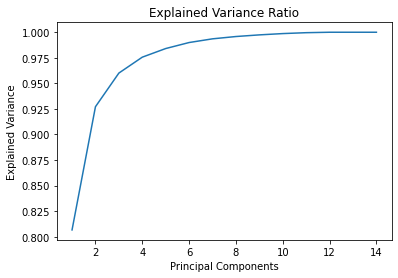

In [642]:
#Test train split
X_train,X_test,y_train,y_test = train_test_split(X_2,y_2,test_size=0.2) #Select Dataset

#Standard scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

'''
#Applying Feature Extraction PCA
pca=PCA()
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''

'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA()
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''

#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=KernelPCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA()
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)

explained_variance = lda.explained_variance_ratio_
print( np.cumsum(explained_variance))
plt.plot(range(1,c), np.cumsum(explained_variance))
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()

In [79]:
features=get_resnet_features('./dataset/Yale_face_database/')
print(features.shape)

(165, 2048)


In [107]:
X_trains,X_tests,y_train,y_test = train_test_split(X,y,test_size=0.2)#Select Dataset put X as features for VGG and Resnet 
print(X_trains.shape)

(537, 4096)


In [109]:
#Logistic Regression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_trains)
X_test = sc.transform(X_tests)

'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=KernelPCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0,max_iter=400)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(classifier.score(X_test,y_test))
print(cm)

0.3037037037037037
[[2 0 0 5 0 1 0 3]
 [0 2 2 3 0 1 0 0]
 [2 0 7 3 2 0 3 1]
 [4 1 3 2 0 1 1 3]
 [1 1 3 5 7 4 1 4]
 [1 0 2 2 0 4 3 3]
 [1 0 3 7 2 0 8 0]
 [0 0 4 4 0 3 1 9]]


c:\users\suchi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [111]:
#SVC classifier
sc = StandardScaler()
X_train = sc.fit_transform(X_trains)
X_test = sc.transform(X_tests)

'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=KernelPCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)

from sklearn.svm import SVC
classifier_svm_kernel = SVC(C=1)
classifier_svm_kernel.fit(X_train,y_train)
y_pred = classifier_svm_kernel.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(classifier_svm_kernel.score(X_test,y_test))                            
print(cm)

0.2222222222222222
[[0 1 2 2 0 2 2 2]
 [0 1 3 3 0 1 0 0]
 [5 0 7 3 2 1 0 0]
 [3 0 3 2 0 4 3 0]
 [2 1 5 4 6 4 2 2]
 [3 0 3 2 0 3 1 3]
 [7 0 4 5 2 0 3 0]
 [0 0 5 5 0 3 0 8]]


In [112]:
#Decision Tree Classifier
sc = StandardScaler()
X_train = sc.fit_transform(X_trains)
X_test = sc.transform(X_tests)
'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=KernelPCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)

from sklearn.tree import DecisionTreeClassifier
decisiontree=DecisionTreeClassifier()
decisiontree.fit(X_train,y_train)
y_pred=decisiontree.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(decisiontree.score(X_test,y_test))                            
print(cm)


0.2518518518518518
[[ 2  3  0  4  1  0  0  1]
 [ 0  2  1  5  0  0  0  0]
 [ 1  2  6  1  7  1  0  0]
 [ 0  1  3 10  0  0  1  0]
 [ 0  6  4  6  5  2  0  3]
 [ 0  3  0  5  1  2  1  3]
 [ 0  1  3  7  4  2  3  1]
 [ 0  2  7  5  1  1  1  4]]


0.25925925925925924
[[ 1  2  0  0  0  2  2  4]
 [ 0  2  0  2  0  2  0  2]
 [ 0  1  7  2  1  1  4  2]
 [ 2  1  3  1  0  1  4  3]
 [ 2  1  3  1  5  4  5  5]
 [ 1  0  3  1  0  0  3  7]
 [ 3  0  2  1  2  2 10  1]
 [ 1  0  7  1  1  1  1  9]]


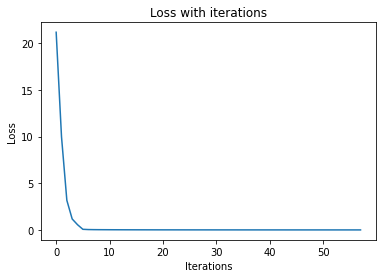

In [113]:
#MultiLayer Perceptron
sc = StandardScaler()
X_train = sc.fit_transform(X_trains)
X_test = sc.transform(X_tests)
'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=KernelPCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)

from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(hidden_layer_sizes=300,learning_rate_init=0.001,max_iter=700)
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(mlp.score(X_test,y_test))                            
print(cm)

#print(mlp.loss_curve_)
#print(mlp.n_iter_)

plt.plot(range(0,mlp.n_iter_), mlp.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Loss with iterations')
plt.show()

3.Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? 

In [116]:
from sklearn.manifold import TSNE
import seaborn as sns
import time

In [134]:
features=get_vgg_features('./dataset/IMFDB/')
print(features.shape)

(400, 4096)


In [137]:
time_start = time.time()

'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_pca=pca.fit_transform(X)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_pca=pca.fit_transform(X)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X.shape
c =len(np.unique(y))
pca=PCA(n-c)
X_pca=pca.fit_transform(X)
lda=LDA(n_components=7)
X_pca=lda.fit_transform(X,y)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X.shape
c =len(np.unique(y))
pca=KernelPCA(n-c)
X_pca=pca.fit_transform(X)
lda=LDA(n_components=10,store_covariance=True)
X_pca=lda.fit_transform(X_pca,y)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(X_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.21896624565124512 seconds


<AxesSubplot:>

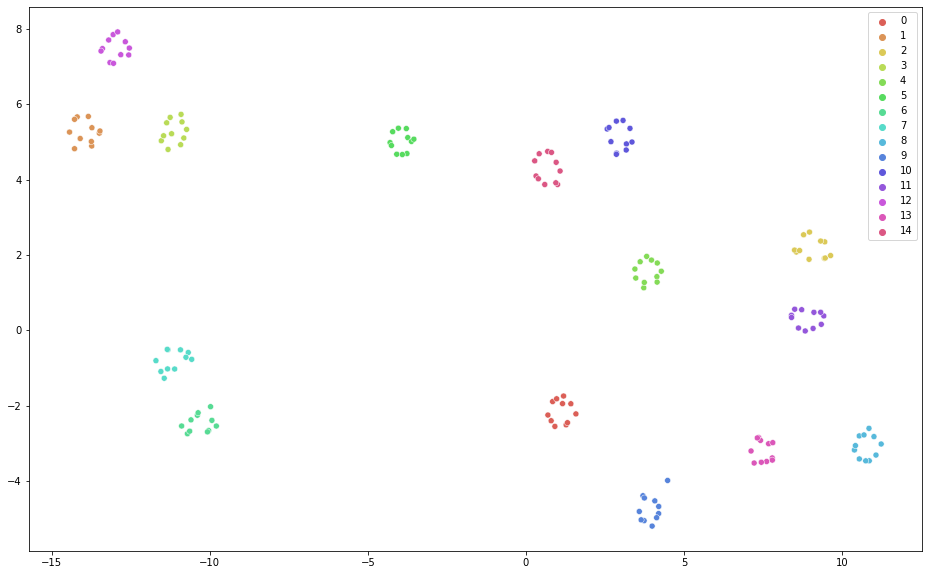

In [138]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_pca_results[:,0], y=tsne_pca_results[:,1],hue=y_2,palette=sns.color_palette("hls", 15))

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

4(c)Show empirical results  with  all  the  representations

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [204]:
features=get_resnet_features('./dataset/Yale_face_database/')
print(features.shape)

(165, 2048)


In [212]:
from sklearn.preprocessing import StandardScaler
X_trains,X_tests,y_train,y_test = train_test_split(X_2,y_2,test_size=0.2)
print(X_trains.shape)
sc = StandardScaler()
X_train = sc.fit_transform(X_trains)
X_test = sc.transform(X_tests)
'''
#Applying Feature Extraction KernelPCA
pca=KernelPCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction PCA
pca=PCA(n=100)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
'''
'''
#Applying Feature Extraction Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)
'''
#Applying Feature Extraction Kernel Fischer
[n,d]=X_train.shape
c =len(np.unique(y_train))
pca=PCA(n-c)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
lda=LDA(n_components=7)
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)

knn= KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(knn.score(X_test, y_test))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))


(132, 4096)
0.9393939393939394
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
